In [46]:
#Downloading libraries

%pip install catboost optuna optuna-integration seaborn scikit-learn openpyxl nbformat

  Obtaining dependency information for nbformat from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4bc3cba53c9f038ab6e9ed964e22f1/nbformat-5.10.4-py3-none-any.whl.metadata
  Obtaining dependency information for fastjsonschema>=2.15 from https://files.pythonhosted.org/packages/9c/b9/79691036d4a8f9857e74d1728b23f34f583b81350a27492edda58d5604e1/fastjsonschema-2.19.1-py3-none-any.whl.metadata
  Obtaining dependency information for jsonschema>=2.6 from https://files.pythonhosted.org/packages/c8/2f/324fab4be6fe37fb7b521546e8a557e6cf08c1c1b3d0b4839a00f589d9ef/jsonschema-4.22.0-py3-none-any.whl.metadata
  Obtaining dependency information for attrs>=22.2.0 from https://files.pythonhosted.org/packages/e0/44/827b2a91a5816512fcaf3cc4ebc465ccd5d598c45cefa6703fcf4a79018f/attrs-23.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for jsonschema-specifications>=2023.03.6 from https://files.pythonhosted.org/packages/ee/07/44bd408781594c4d0a027666ef27fab1e441

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
# Importing libraries and setting necessery settings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import all the required models and methods
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler


%matplotlib inline
plt.style.use("seaborn-v0_8")

# **GBM - CatBoost**

In [11]:
# Importing necessary libraries

from catboost import CatBoostRegressor, Pool
from pandas.api.types import is_numeric_dtype
from optuna.integration import CatBoostPruningCallback

In [14]:
cat_data = pd.read_excel("PRODATA.xlsx")

In [15]:
cat_data = cat_data[(cat_data['trans_date'] > "2021-01-01")]

In [16]:
cat_data.head()

,trans_id,trans_type,trans_date,prop_type,prop_stype,prop_usage,location_id,location_name,capacity,prop_area(sq/m),sale_price(sq/m),prop_value
19,2-13-2021-896,Mortgages,2021-01-25,Villa,Villa,Residential,434,Wadi Al Safa 6,2 B/R,180.24,6857.35,1235968
20,1-102-2022-16814,Sales,2022-06-23,Unit,Flat,Residential,317,Jumeirah First,3 B/R,189.37,25833.36,4892064
21,2-13-2022-18993,Mortgages,2022-12-05,Villa,Villa,Residential,434,Wadi Al Safa 6,2 B/R,172.18,8363.34,1440000
22,1-102-2023-4596,Sales,2023-01-30,Unit,Flat,Residential,350,Al Thanyah Fifth,Studio,35.67,15627.05,557417
30,2-13-2021-12893,Mortgages,2021-10-12,Villa,NaN,Residential,523,Al Hebiah Third,NaN,253.58,6955.40,1763750


In [17]:
cat_data.describe()

,trans_date,location_id,prop_area(sq/m),sale_price(sq/m),prop_value
count,303827,303827.000000,3.038270e+05,303827.000000,3.038270e+05
mean,2022-10-17 22:04:19.323891200,424.149746,2.489818e+02,15226.801663,2.646562e+06
min,2021-01-04 00:00:00,230.000000,2.800000e-01,0.000000,1.000000e+00
25%,2022-02-21 00:00:00,364.000000,6.649000e+01,8330.070000,7.450000e+05
50%,2022-12-05 00:00:00,441.000000,1.008700e+02,12433.170000,1.380000e+06
75%,2023-07-14 00:00:00,467.000000,1.709900e+02,19542.630000,2.400000e+06
max,2024-01-23 00:00:00,531.000000,4.508390e+06,674778.760000,2.400000e+09
std,NaN,65.090220,8.939807e+03,11065.180611,1.542924e+07


In [20]:
# For further simplicity the target row should be the last

cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275230 entries, 19 to 958498
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   trans_id          275230 non-null  object        
 1   trans_type        275230 non-null  object        
 2   trans_date        275230 non-null  datetime64[ns]
 3   prop_type         275230 non-null  object        
 4   prop_stype        275230 non-null  object        
 5   prop_usage        275230 non-null  object        
 6   location_id       275230 non-null  int64         
 7   location_name     275230 non-null  object        
 8   capacity          275230 non-null  object        
 9   prop_area(sq/m)   275230 non-null  float64       
 10  sale_price(sq/m)  275230 non-null  float64       
 11  prop_value        275230 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 27.3+ MB


In [19]:
cat_data.dropna(inplace=True)


In [32]:
cat_data.drop(["trans_date", "trans_id", "location_name"], axis = 1, inplace = True)

In [34]:
# Getting categorical feature indecies

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies


def convert_cats(X):
    for col in categorical_indicies:
        X[col] = X[col].astype('category')


categorical_indicies = get_categorical_indicies(cat_data)
# Попробовать без неё convert_cats(cat_data)

In [33]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275230 entries, 19 to 958498
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   trans_type        275230 non-null  object 
 1   prop_type         275230 non-null  object 
 2   prop_stype        275230 non-null  object 
 3   prop_usage        275230 non-null  object 
 4   location_id       275230 non-null  int64  
 5   capacity          275230 non-null  object 
 6   prop_area(sq/m)   275230 non-null  float64
 7   sale_price(sq/m)  275230 non-null  float64
 8   prop_value        275230 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 21.0+ MB


In [35]:
training_set, validation_set = train_test_split(cat_data, test_size=0.1, random_state=777)

In [36]:
target = "prop_value"
cat_features = [col for col in cat_data.columns if col != target]

In [38]:
# Find best hyperparameters using Optuna library

def objective(trial, data = training_set[cat_features], target = training_set[target]):

    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)

    param = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 500),
        "learning_rate": trial.suggest_float('learning_rate', 0, 1),
        "depth": trial.suggest_int('depth', 4, 12),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0, 10),
        "od_wait": trial.suggest_int("od_wait", 10, 25),
        "border_count": trial.suggest_int('border_count', 100, 500),
        "random_strength": trial.suggest_float('random_strength', 0, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["Depthwise", "SymmetricTree"])
    }

    if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)

    else:
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    if param["grow_policy"] == "Depthwise":
      param["min_data_in_leaf"] = trial.suggest_int('min_data_in_leaf', 1, 500)

    model = CatBoostRegressor(
        loss_function = 'MAPE',
        eval_metric = "MAPE",
#        task_type = 'GPU',
        random_state = 777,
        use_best_model = True,
        od_type = "Iter",
        cat_features = categorical_indicies,
        per_float_feature_quantization = '0:border_count=1024',
        **param
    )

    pruning_callback = CatBoostPruningCallback(trial, "MAPE")


    model.fit(train_x, train_y, eval_set = [(test_x, test_y)],
              verbose = False, callbacks=[pruning_callback])

    pruning_callback.check_pruned()

    preds = model.predict(test_x)
#    preds = np.fabs(model.predict(test_x))
    mape = mean_absolute_percentage_error(test_y, preds)

    return mape



sampler = TPESampler(multivariate = True, group = True, seed = 777)
study = optuna.create_study(study_name = "catboost", sampler = sampler,)
study.optimize(objective, n_trials = 200)
trial = study.best_trial

print("Number of finished trials: ", len(study.trials))
print("Best trial:", trial.number)
print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\Aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\Aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\samplers\_tpe\sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-05-08 01:39:59,676] A new study created in memory with name: catboost


C:\Users\Aleks\AppData\Local\Temp\ipykernel_8604\859435403.py:46: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
[I 2024-05-08 01:40:09,886] Trial 0 finished with value: 0.44573425431744024 and parameters: {'n_estimators': 161, 'learning_rate': 0.3023566097075212, 'depth': 4, 'l2_leaf_reg': 4.598603416089688, 'od_wait': 23, 'border_count': 471, 'random_strength': 7.269889843190701, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'bagging_temperature': 5.896137534558643, 'min_data_in_leaf': 172}. Best is trial 0 with value: 0.44573425431744024.
C:\Users\Aleks\AppData\Local\Temp\ipykernel_8604\859435403.py:46: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
[I 2024-05-08 01:40:39,521] Trial 1 finished with

Number of finished trials:  200
Best trial: 176
  Value:  0.07008948738808198
  Params: 
    n_estimators: 337
    learning_rate: 0.46510940176204085
    depth: 10
    l2_leaf_reg: 6.752884443750061
    od_wait: 11
    border_count: 167
    random_strength: 0.030578303342516877
    bootstrap_type: Bayesian
    grow_policy: Depthwise
    bagging_temperature: 9.992836685513474
    min_data_in_leaf: 209


In [39]:
# History of optimization

optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 13, 20, 26, 33, 34, 38, 39, 40, 42, 62, 94,
                    116, 121, 124, 130, 145, 146, 147, 160, 176, 182, 183, 191,
                    196, 197],
              'y': [0.44573425431744024, 0.31325194663775785, 0.1923539626301527,
                    0.3804503000272274, 0.2970609810741265, 0.12990407333752463,
                    0.15121286497097775, 0.22576668957663523, 0.0967718003435825,
                    0.10418792477358048, 0.13708221040718185, 0.1327470550306914,
                    0.10064331461907569, 0.09606316115412764, 0.14638629223328806,
                    0.08669020046935776, 0.09527976422901176, 0.10569945141994165,
                    0.09343713718816066, 0.09223083412710958, 0.10239509242704552,
                    0.089995347060581, 0.10385132433748773, 0.09771281553616255,
                    0.07008948738808198, 0.09048342362255352, 0.07914363065743762,
                    0.08218027339315814, 0.09760503867966844, 0.08450421488482183]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
                    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
                    123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
                    135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
                    147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
                    159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
                    171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
                    183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
                    195, 196, 197, 198, 199],
              'y': [0.44573425431744024, 0.31325194663775785, 0.1923539626301527,
                    0.1923539626301527, 0.1923539626301527, 0.1923539626301527,
                    0.1923539626301527, 0.1923539626301527, 0.1923539626301527,
                    0.1923539626301527, 0.1923539626301527, 0.1923539626301527,
                    0.1923539626301527, 0.12990407333752463, 0.12990407333752463,
                    0.12990407333752463, 0.12990407333752463, 0.12990407333752463,
                    0.12990407333752463, 0.12990407333752463, 0.12990407333752463,
                    0.12990407333752463, 0.12990407333752463, 0.12990407333752463,
                    0.12990407333752463, 0.12990407333752463, 0.12990407333752463,
                    0.12990407333752463, 0.12990407333752463, 0.12990407333752463,
                    0.12990407333752463, 0.12990407333752463, 0.12990407333752463,
                    0.0967718003435825, 0.0967718003435825, 0.0967718003435825,
                    0.0967718003435825, 0.0967718003435825, 0.0967718003435825,
                    0.0967718003435825, 0.0967718003435825, 0.0967718003435825,
                    0.09606316115412764, 0.09606316115412764, 0.09606316115412764,
                    0.09606316115412764, 0.09606316115412764, 0.09606316115412764,
                    0.09606316115412764, 0.09606316115412764, 0.09606316115412764,
                    0.09606316115412764, 0.09606316115412764, 0.09606316115412764,
                    0.09606316115412764, 0.09606316115412764, 0.09606316115412764,
                    0

In [40]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 2, 4, 13, 20, 26, 33, 34, 38, 39, 40, 42,
                                   62, 94, 116, 121, 124, 130, 145, 146, 147, 160,
                                   176, 182, 183, 191, 196, 197],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [5.896137534558643, 1.228516961349656, 4.243219898452257,
                    9.014036856436508, 9.987073306041054, 9.756866720834928,
                    9.911277411849381, 9.8344912810759, 9.864930915569468,
                    8.096631895075989, 7.64697249569321, 7.412643687048379,
                    9.951184484014943, 8.663707807805357, 9.985819159361096,
                    9.976941278516367, 8.754107426125122, 8.558265773497306,
                    9.983721006190395, 9.988003585502463, 9.903001026279528,
                    9.995309448742987, 9.992836685513474, 9.915390407426234,
                    9.89872496891705, 9.897144646417793, 8.892351413478782,
                    7.577733046671767],
              'xaxis': 'x',
              'y': [0.44573425431744024, 0.1923539626301527, 0.2970609810741265,
                    0.12990407333752463, 0.15121286497097775, 0.22576668957663523,
                    0.0967718003435825, 0.10418792477358048, 0.13708221040718185,
                    0.1327470550306914, 0.10064331461907569, 0.09606316115412764,
                    0.14638629223328806, 0.08669020046935776, 0.09527976422901176,
                    0.10569945141994165, 0.09343713718816066, 0.09223083412710958,
                    0.10239509242704552, 0.089995347060581, 0.10385132433748773,
                    0.09771281553616255, 0.07008948738808198, 0.09048342362255352,
                    0.07914363065743762, 0.08218027339315814, 0.09760503867966844,
                    0.08450421488482183],
              'yaxis': 'y'},
             {'marker': {'color': [0, 1, 2, 3, 4, 13, 20, 26, 33, 34, 38, 39, 40,
                                   42, 62, 94, 116, 121, 124, 130, 145, 146, 147,
                                   160, 176, 182, 183, 191, 196, 197],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [Bayesian, Bernoulli, Bayesian, Bernoulli, Bayesian, Bayesian,
                    Bayesian, Bayesian, Bayesian, Bayesian, B

In [41]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [od_wait (IntDistribution):
                                0.008265676434615248<extra></extra>, n_estimators
                                (IntDistribution):
                                0.022464104142137835<extra></extra>, bootstrap_type
                                (CategoricalDistribution):
                                0.06436092701817185<extra></extra>, grow_policy
                                (CategoricalDistribution):
                                0.06879436937571072<extra></extra>, border_count
                                (IntDistribution):
                                0.0771776080706243<extra></extra>, l2_leaf_reg
                                (FloatDistribution):
                                0.15143309297065063<extra></extra>, random_strength
                                (FloatDistribution):
                                0.16483829364809532<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.18228877549131486<extra></extra>, depth
                                (IntDistribution):
                                0.2603771528486791<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, 0.02, 0.06, 0.07, 0.08, 0.15, 0.16, 0.18, 0.26],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.008265676434615248, 0.022464104142137835,
                    0.06436092701817185, 0.06879436937571072, 0.0771776080706243,
                    0.15143309297065063, 0.16483829364809532, 0.18228877549131486,
                    0.2603771528486791],
              'y': [od_wait, n_estimators, bootstrap_type, grow_policy,
                    border_count, l2_leaf_reg, random_strength, learning_rate,
                    depth]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [42]:
# Creating the model with best hyperparameters

cat_model = CatBoostRegressor(loss_function = 'MAPE',
#                        task_type = 'GPU',
                        random_state = 777,
                        od_type = "Iter",
                        per_float_feature_quantization = '0:border_count=1024',
                        **study.best_trial.params)

In [43]:
# Creating train Pool

cat_train_data = Pool(
    data = training_set[cat_features],
    label = training_set[target],
    cat_features = categorical_indicies,
)

In [44]:
cat_model.fit(cat_train_data, verbose = True)

0:	learn: 0.5540794	total: 269ms	remaining: 1m 30s
1:	learn: 0.3968552	total: 414ms	remaining: 1m 9s
2:	learn: 0.2932251	total: 553ms	remaining: 1m 1s
3:	learn: 0.2198262	total: 808ms	remaining: 1m 7s
4:	learn: 0.1954669	total: 1.06s	remaining: 1m 10s
5:	learn: 0.1809710	total: 1.28s	remaining: 1m 10s
6:	learn: 0.1690129	total: 1.56s	remaining: 1m 13s
7:	learn: 0.1618301	total: 1.76s	remaining: 1m 12s
8:	learn: 0.1605339	total: 1.97s	remaining: 1m 11s
9:	learn: 0.1595196	total: 2.12s	remaining: 1m 9s
10:	learn: 0.1563227	total: 2.34s	remaining: 1m 9s
11:	learn: 0.1548337	total: 2.54s	remaining: 1m 8s
12:	learn: 0.1541472	total: 2.68s	remaining: 1m 6s
13:	learn: 0.1508042	total: 2.88s	remaining: 1m 6s
14:	learn: 0.1482707	total: 3.14s	remaining: 1m 7s
15:	learn: 0.1432159	total: 3.32s	remaining: 1m 6s
16:	learn: 0.1402125	total: 3.53s	remaining: 1m 6s
17:	learn: 0.1399055	total: 3.66s	remaining: 1m 4s
18:	learn: 0.1387042	total: 3.88s	remaining: 1m 5s
19:	learn: 0.1381386	total: 4.1s	re

Text(0.5, 1.0, 'Feature Importance')

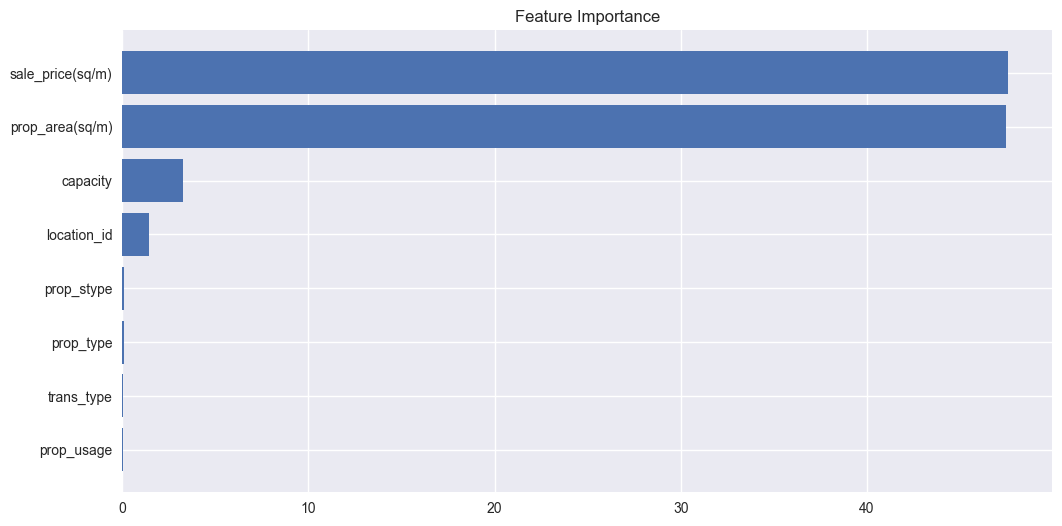

In [48]:
# Plotting feature importance

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(cat_features)[sorted_idx], feature_importance[sorted_idx])
plt.title('Feature Importance')

In [49]:
validation_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27523 entries, 711380 to 182273
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trans_type        27523 non-null  object 
 1   prop_type         27523 non-null  object 
 2   prop_stype        27523 non-null  object 
 3   prop_usage        27523 non-null  object 
 4   location_id       27523 non-null  int64  
 5   capacity          27523 non-null  object 
 6   prop_area(sq/m)   27523 non-null  float64
 7   sale_price(sq/m)  27523 non-null  float64
 8   prop_value        27523 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.1+ MB


In [50]:
# Creating Test Pool and predicting

test = Pool(
    data = validation_set[cat_features],
    cat_features = categorical_indicies,
)
y_pred = cat_model.predict(test)

In [51]:
validation_error = mean_absolute_percentage_error(validation_set[target], y_pred)
print("validation:", validation_error, "test:", study.best_trial.value)

validation: 1.8332658775451625 test: 0.07008948738808198
